In [1]:
import numpy as np
import xarray as xr
import pyremo as pr
import cmaps
import glob
import xesmf as xe
from REMO2020_mod import modelclass, CLARA_cfc_open_process, season_mean, get_domain, open_mfdataset, domainclass, plotclass, clara_plotter_seas_wera5

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernelR2020/share/proj failed


In [2]:
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/scratch/g/g300096/dask/tmp'})
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300096/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/g300096/levante-spawner-preset//proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45259,Workers: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:39535,Total threads: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/33059/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:45289,


In [3]:
# define the runs to be plotted
modelruns =[] # init

modelruns.append(modelclass("056524","REMO2015",False))
modelruns.append(modelclass("036030","REMO2020$_{27}$",True))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True))

In [4]:
# give suffix (the main name for the plots)
figpath = './figures/'
prefix = 'CLARAv3_CC_wera5_seas_'
suffix = 'REMO2020_2749_main'

In [5]:
# define star year and end year
ystart=2001
yend=2010

In [6]:
# REMO and EOBS datapath
rdata = './data_in/model_data/'
claradata = './data_in/CLARA_CC/'
era5tcc = './data_in/ERA5/Cloud_Cover/tcc/'

In [7]:
# Cut global clara to these coordinates (choose them so that the remo domain is within)
min_lon = -80.0
min_lat = 10.0 
max_lon = 80.0 
max_lat = 86.0

In [8]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

In [9]:
# open clara data
dsclaramon = CLARA_cfc_open_process(claradata,ystart,yend,min_lat,max_lat,min_lon,max_lon)

In [10]:
# open ERA5 tcc data, change coordinates and cut the domain
dsera5mon = xr.open_dataset(era5tcc+'E_1_5_sf_an_1M_164_E1sf00_1M_'+str(ystart)+'-'+str(yend)+'_164.nc')
dsera5mon.coords["lon"] = (dsera5mon.coords['lon'] + 180) % 360 - 180
dsera5mon = dsera5mon.sortby(dsera5mon.lon)
dsera5mon.coords["lat"] = (dsera5mon.coords['lat'] + 90) % 180 - 90
dsera5mon = dsera5mon.sortby(dsera5mon.lat).sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

In [11]:
# prepare regridder to regrid CLARA data to  ERA5
regridder = xe.Regridder(dsclaramon, dsera5mon, "bilinear")

In [12]:
# regrid data
dsclaramone5 = regridder(dsclaramon)

In [13]:
# Merge datasets to get indentical axis
era5clara = xr.merge([dsera5mon, dsclaramone5], compat="override", join="override")

In [14]:
yearlist = np.arange(ystart,yend+1)
for obj in modelruns:
    for year in yearlist:
        pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
        obj.filenames += glob.glob(pattern)
    obj.filenames.sort()

In [15]:
# Target grid
trggrid = "EUR-11"
target_grid = get_domain(trggrid)

In [16]:
# Set halo zone length (will be cutted out)
halo = 8

In [17]:
# for regriddder, we need haloless data
target_grid = target_grid.isel(rlat=slice(halo+1,target_grid.sizes["rlat"]-halo+1), rlon=slice(halo+1,target_grid.sizes["rlon"]-halo+1))

In [18]:
# prepare regridder to regrid REMO data to era5
regridder = xe.Regridder(target_grid, dsera5mon, "bilinear")

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [19]:
# calculate the CC difference to CLARA
ii = 0
for obj in modelruns:
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    REMOmon = pr.parse_dates(ds[["ACLCOV"]])
    # cut halo
    REMOmon = REMOmon.isel(rlat=slice(halo+1,REMOmon.sizes["rlat"]-halo+1), rlon=slice(halo+1,REMOmon.sizes["rlon"]-halo+1)).compute()
    #
    CC_clgrid = regridder(REMOmon)
    #
    if(ii == 0):
        # absolute values
        abs_vals = season_mean(dsclaramone5).clavar.where(CC_clgrid.ACLCOV.sum(dim="time") > 0.0).compute()
        
        # ERA5 values
        era5clarad = season_mean(era5clara.TCC-era5clara.clavar).where(CC_clgrid.ACLCOV.sum(dim="time") > 0.0).compute()
    # Merge data (get identical coordinates)
    CC_all = xr.merge([CC_clgrid, dsclaramone5], compat="override", join="override")
    # substract the values, finally making seasonal means
    obj.vardiff = season_mean((CC_all.ACLCOV-CC_all.clavar).squeeze()).where(CC_all.ACLCOV.sum(dim="time") > 0.0).compute()
    # not supported, set to zero
    obj.mask = np.zeros(len(seasons))
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.70 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 85.09 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending

In [20]:
# define the domains to be plotted
domaininfo =[] # init
domaininfo.append(domainclass("EU",[-22.5,47.5,30,72.5], wspace=0.1, hspace=0.35))

In [21]:
# define plotclasses for absolute and difference (model) plots
absplotc = plotclass(label='Cloud cover', lspace=np.linspace(0,1,20), vmin=0, vmax=1.0, linvert=False, cmapp=cmaps.BlAqGrYeOrReVi200)
modplotc = plotclass(label='$\Delta$Cloud cover', lspace=np.linspace(0,1,12), vmin=-0.3, vmax=0.3, linvert=False, cmapp=cmaps.BlueWhiteOrangeRed)

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecate

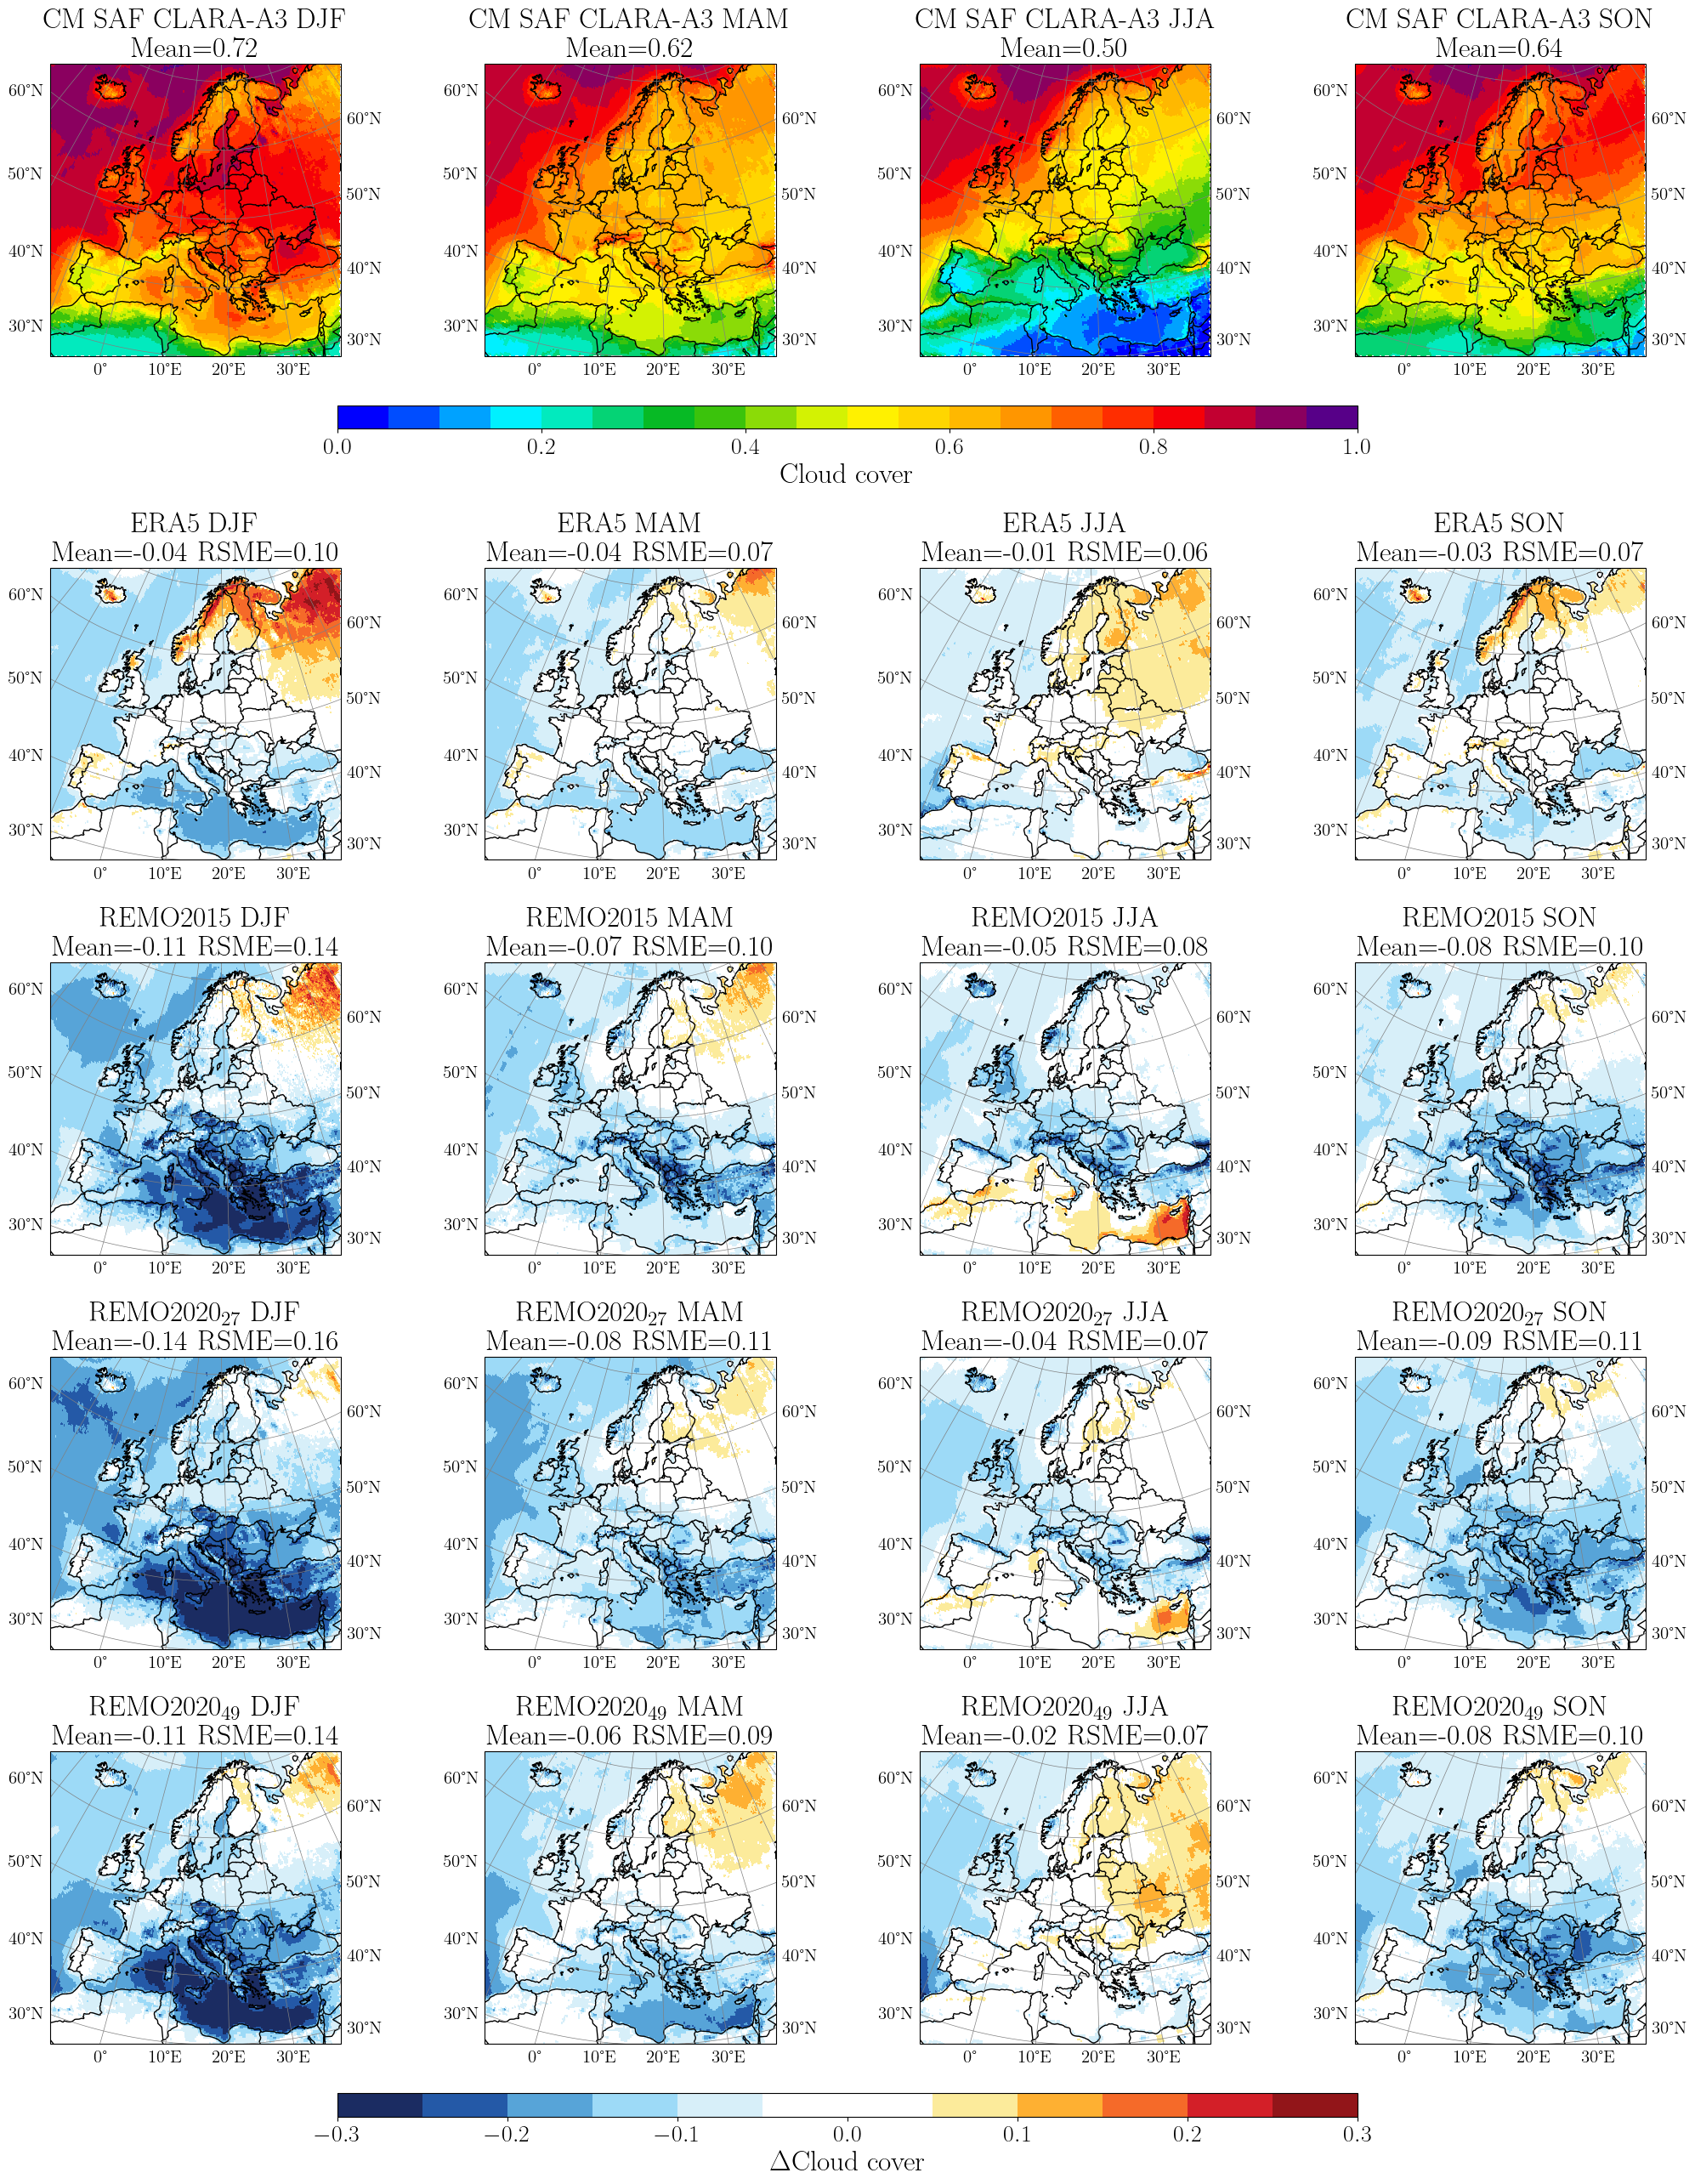

In [22]:
# Loop over domains
for dom in range(len(domaininfo)):
    # Create figure name
    figname=prefix+domaininfo[dom].name+'_'+suffix
    # Call plotter (we can use the eobs plotter directly)
    clara_plotter_seas_wera5(absplotc,modplotc,domaininfo[dom],pole,modelruns,"CM SAF CLARA-A3",abs_vals,era5clarad,seasons,False,figpath,figname)